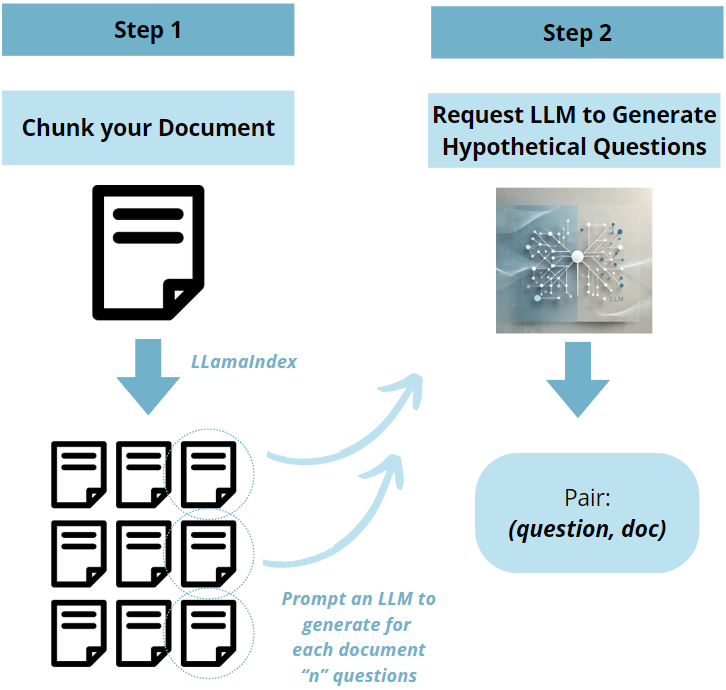

In [2]:
from IPython.display import Image, display
img_path = path+'synthetic_data_llamaindex_financial_report.png'
display(Image(filename=img_path))

# How to Generate Synthetic Data for a Financial Report Using LlamaIndex

✅ Generating synthetic data can be a game-changer in financial analysis, and with LlamaIndex, it's both efficient and cost-effective. Here's how you can leverage an LLM to create valuable insights without the need for manual labeling.

✅ The Core Idea: Use a Large Language Model (LLM) to generate hypothetical questions that align perfectly with specific pieces of context. This approach allows for the scalable creation of synthetic pairs of (query, relevant documents) without relying on human intervention.

[Hanane D](https://www.linkedin.com/in/hanane-d-algo-trader)

# Install Lib

In [61]:
!pip install llama-index -q

# Load pdf

In [62]:
!wget "https://d18rn0p25nwr6d.cloudfront.net/CIK-0001018724/c7c14359-36fa-40c3-b3ca-5bf7f3fa0b96.pdf" -O amzn_2023_10k.pdf

--2024-08-29 11:03:20--  https://d18rn0p25nwr6d.cloudfront.net/CIK-0001018724/c7c14359-36fa-40c3-b3ca-5bf7f3fa0b96.pdf
Resolving d18rn0p25nwr6d.cloudfront.net (d18rn0p25nwr6d.cloudfront.net)... 3.161.141.53, 3.161.141.55, 3.161.141.72, ...
Connecting to d18rn0p25nwr6d.cloudfront.net (d18rn0p25nwr6d.cloudfront.net)|3.161.141.53|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 800598 (782K) [application/pdf]
Saving to: ‘amzn_2023_10k.pdf’

amzn_2023_10k.pdf   100%[===================>] 781.83K  --.-KB/s    in 0.08s   

2024-08-29 11:03:20 (9.79 MB/s) - ‘amzn_2023_10k.pdf’ saved [800598/800598]



# Chunk PDF

In [63]:
import json

from llama_index.core import SimpleDirectoryReader
from llama_index.core.node_parser import SimpleNodeParser
# from llama_index.core.schema import MetadataMode

In [65]:
files = ['amzn_2023_10k.pdf']
loader = SimpleDirectoryReader(input_files=files)
documents = loader.load_data()
print(f"len of documents {len(documents)}")

len of documents 94


In [66]:
parser = SimpleNodeParser.from_defaults()
nodes = parser.get_nodes_from_documents(documents, show_progress=True)
print(f"len of nodes {len(nodes)}")
corpus = {node.node_id: node.get_content() for node in nodes}

Parsing nodes:   0%|          | 0/94 [00:00<?, ?it/s]

len of nodes 118


In [67]:
import re
import uuid

from llama_index.llms.openai import OpenAI
from tqdm.notebook import tqdm

In [68]:
import nest_asyncio
nest_asyncio.apply()

from google.colab import userdata
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')

# Design a specific prompt to request LLM to generate questions:

In [69]:
prompt_template = """\
    Context information is below.

    ---------------------
    {context_str}
    ---------------------

    Given the context information and not prior knowledge.
    generate only questions based on the below query.

    You are a financial analyst.
    Your task is to setup {num_questions_per_chunk} questions for a 10K financial report.
    The questions should be diverse in nature across the document.
    The questions should contain key concepts and metrics in a financial report.
    Some of the questions should contain numbers, quarters and years to reflect the nature of a financial report.
    Restrict the questions to the context information provided."
    """

# Generate Hypothetical Questions

In [ ]:
%%time
num_questions_per_chunk = 3
llm = OpenAI(model='gpt-4o-mini', api_key = OPENAI_API_KEY)
queries = {}
relevant_context = {}

#Code from LlamaIndex blog: https://www.llamaindex.ai/blog/fine-tuning-embeddings-for-rag-with-synthetic-data-e534409a3971
for node_id, text in tqdm(corpus.items()):
  query = prompt_template.format(context_str=text, num_questions_per_chunk=num_questions_per_chunk)
  response = llm.complete(query)
  result = str(response).strip().split("\n")
  questions = [
            re.sub(r"^\d+[\).\s]", "", question).strip() for question in result
        ]
  questions = [question for question in questions if len(question) > 0]
  print(questions)
  for question in questions:
    question_id = str(uuid.uuid4())
    queries[question_id] = question
    relevant_context[question_id] = [node_id]

In [ ]:
#Examples of questions:
['What was the total revenue reported by Amazon.com, Inc. for the fiscal year ended December 31, 2023, and how does this figure compare to the previous fiscal year?', "Can you provide details on the company's net income or loss for the fourth quarter of 2023, and what factors contributed to this financial outcome?", 'What is the significance of Amazon.com, Inc. being classified as a large accelerated filer, and how does this classification impact its reporting requirements under the Securities Exchange Act of 1934?']
['What is the aggregate market value of voting stock held by non-affiliates of the registrant as of June 30, 2023, and how does this figure compare to the previous fiscal year?', "As of January 24, 2024, how many shares of common stock are outstanding, and what implications might this have for the company's earnings per share (EPS) calculation?", "Does the registrant's financial statements reflect any corrections of errors to previously issued financial statements, and if so, were any of these corrections classified as restatements requiring a recovery analysis of incentive-based compensation for executive officers?"]
['What were the key financial metrics reported in Item 7, Management’s Discussion and Analysis of Financial Condition and Results of Operations, for the fiscal year ended December 31, 2023, and how do they compare to the previous fiscal year?', "In Item 1A, Risk Factors, what are the top three risks identified that could potentially impact Amazon.com, Inc.'s financial performance in 2024, and how might these risks affect revenue projections?", "According to Item 8, Financial Statements and Supplementary Data, what was the total revenue reported for the fourth quarter of 2023, and how does this figure align with the company's overall annual revenue for the fiscal year?"]
['What were the net sales figures for Amazon.com, Inc. in the North America and International segments for the fiscal year ended December 31, 2022, as detailed in Item 8 of Part II, “Financial Statements and Supplementary Data — Note 10 — Segment Information”?', 'How does Amazon.com, Inc. measure its operational excellence in relation to customer service, and what specific metrics or performance indicators are used to evaluate this aspect in the Annual Report?', 'In the context of Amazon Web Services (AWS), what percentage of total revenue did AWS contribute in the most recent quarter reported, and how does this compare to the same quarter in the previous year?']
['What were the sales volume trends observed during the fourth quarter of 2023, and how did they compare to previous years in terms of percentage growth or decline?', "As of December 31, 2023, what is the total number of full-time and part-time employees, and how does this figure reflect the company's investment in human capital compared to the previous year?", "How does the competitive landscape, including the presence of companies with greater resources and brand recognition, impact the company's pricing strategy and overall revenue generation in the fiscal year 2023?"]
['What percentage of Amazon employees globally have participated in the Career Choice program, and how does this investment in employee education funding impact overall employee retention rates in the last fiscal year?', 'How much has Amazon invested in safety improvements, including capital improvements and new safety technology, over the past three years, and what measurable impact has this had on workplace incident rates during that period?', 'In the most recent quarter, what were the competitive pay and benefits expenses as a percentage of total operating expenses, and how do these figures compare to the previous quarter and the same quarter last year?']
['What were the total revenues reported by Amazon for the fiscal year ending December 31, 2023, and how does this figure compare to the total revenues for the previous fiscal year?', "Can you provide the operating income for Amazon's Worldwide Amazon Stores segment for the second quarter of 2023, and how does it reflect on the overall profitability of the company?", 'What is the current ratio of Amazon as of January 24, 2024, and how does this liquidity metric compare to the ratio reported in the previous fiscal year?']
['What specific competitive metrics or market share percentages does the company report for its e-commerce and cloud computing segments for the fiscal year ending 2023, and how do these figures compare to the previous fiscal year?', "In the context of the company's expansion into new products and services, what were the total capital expenditures allocated for these initiatives in the last quarter of 2023, and how do these expenditures align with the company's overall investment strategy?", "How has the company's operating income been affected by increased competition and pricing pressures in the retail sector during the first half of 2023, and what specific financial ratios can be used to assess this impact?"]


## Examples

In [71]:
questions

['What specific criteria must be met for the Company to initiate a clawback of Incentive-Based Compensation received by an Executive Officer, and how does this relate to the financial reporting requirements under federal securities laws?',
 'In the event of a financial restatement, what is the time frame for recovering Incentive-Based Compensation received by an Executive Officer, and how is the amount determined based on the restated financial statements?',
 'If a Chief Executive Officer or Chief Financial Officer is found to have engaged in fraud that necessitates a restatement, what specific types of compensation and equity awards are subject to recovery, and what is the time period during which these awards must have been settled or granted?']

# All together

In [ ]:
def synthetic_data_generation(
    corpus,
    num_questions_per_chunk=3,
    prompt_template=None,
):
    """
    Automatically generate hypothetical questions that could be answered with
    doc in the corpus.
    """
    llm = OpenAI(model='gpt-4o-mini')

    prompt_template = prompt_template or """\
    Context information is below.

    ---------------------
    {context_str}
    ---------------------

    Given the context information and not prior knowledge.
    generate only questions based on the below query.

    You are a financial analyst.
    Your task is to setup {num_questions_per_chunk} questions for a 10K financial report.
    The questions should be diverse in nature across the document.
    The questions should contain key concepts and metrics in a financial report.
    Some of the questions should contain numbers, quarters and years to reflect the nature of a financial report.
    Restrict the questions to the context information provided."
    """

    llm = OpenAI(model='gpt-4o-mini', api_key = OPENAI_API_KEY)
    queries = {}
    relevant_context = {}

    #Code from LlamaIndex blog: https://www.llamaindex.ai/blog/fine-tuning-embeddings-for-rag-with-synthetic-data-e534409a3971
    for node_id, text in tqdm(corpus.items()):
      query = prompt_template.format(context_str=text, num_questions_per_chunk=num_questions_per_chunk)
      response = llm.complete(query)
      result = str(response).strip().split("\n")
      questions = [
                re.sub(r"^\d+[\).\s]", "", question).strip() for question in result
            ]
      questions = [question for question in questions if len(question) > 0]
      print(questions)
      for question in questions:
        question_id = str(uuid.uuid4())
        queries[question_id] = question
        relevant_context[question_id] = [node_id]
    return queries, relevant_context